**predicting chess boards**

In [0]:
import numpy as np
import glob
import matplotlib.pyplot as plt
from matplotlib.image import imread
from random import shuffle
from skimage.util.shape import view_as_blocks
from skimage import io, transform
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
import warnings
from google.colab import files, drive
import chess
import tensorflow as tf
import cv2
warnings.filterwarnings('ignore')

Using TensorFlow backend.


**Explanation**: these are the modules that I need for my project. I disabled all the warnings that might appear because of the tensorflow module.

**cell for letting colab access to drive**

In [0]:
drive.mount('/gdrive')
%cd ~

**Explanation**: a cell for connecting the colab notebook to my drive where all the data appears.

**setting the data**

In [0]:
#getting the lists of the paths of the pictures
train = glob.glob("/gdrive/My Drive/*.jpeg")
test = glob.glob("../gdrive/My Drive/test/*.jpeg")

train_size = len(train)
test_size = len(test)

#the function
def process_image(img, downsample_size=200):
    square_size = int(downsample_size/8)
    img_read = cv2.imread(img)
    img_read = cv2.resize(img_read, dsize=(200, 200), interpolation=cv2.INTER_CUBIC)
    tiles = view_as_blocks(img_read, block_shape=(square_size, square_size, 3))
    tiles = tiles.squeeze(axis=2)
    return tiles.reshape(64, square_size, square_size, 3)

**Explanation**: the train and test variables consist the list of all the directories of the pictures that I use for training the neural network, and the pictures I tested the model with.

The function *process_image* downsises the size of the picture to 200x200 pixels so it will save some memory. For any image the square size is set by the square_size variable. Than, I devided the picture to 64 small images, where every image is one square of thee board. The im_read is the matrix converted from the picture, and the tiles is the division of the picture.

During the training if the user wants to increase the size of every photo it should increase the downsample_size variable.

In [0]:
# [0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12]
# [bp, bn, bb, br, bq, bk, wp, wn, wb, wr, wq,  wk,   .]

def board_tokenizer(board):
    pieces = 'pnbrqkPNBRQK.'
    matrix = np.zeros((64,13), dtype=np.float16)
    sboard = str(board)
    for i in range(0,127,2):
        piece = sboard[i]
        indx = pieces.index(piece) 
        matrix[i//2, indx] = 1
    return matrix


**Explanation**: this function converts a board into a matrix of zeros and ones. The board is an actual chess board (it's type is python chess board), and the pieces can be one of the pieces under pieces variable. The lower letters are black's pieces, the bigger are white's, and the dot (.) means that the squaree is empty. Every square is transformed to a list where there is a 1 that symbolises the piece according the table above the function, and zeros elsewhere. There are 64 lists of 13 places each, and a one where according to the piece in the square.  

In [0]:
#works
def convert_name_to_fen(im_name):
    fen = ""
    for i in range(6,len(im_name)):
        if im_name[-i] == "/":
            break
        elif im_name[-i] == "-":
            fen += "/"
        else:
            fen += im_name[-i]
    return fen[::-1] + " w - - 0 1"


**Explanation**: the names of the pictures are the fens of the board, with "-" instead of "/". For example: a path of the picture is "/gdrive/My Drive/4Nr1N-2P5-4N3-7R-3P3k-2N5-3r2K1-2N3b1.jpeg" while it should be "4Nr1N/2P5/4N3/7R/3P3k/2N5/3r2K1/2N3b1 w - - 0 1". Basicly, the function replaces the "-" to "/" and adds the string " w - - 0 1" at the end of the fen.

In [0]:
#probably works
def parse_image_to_fen(pic):
    fen = convert_name_to_fen(pic)
    board = chess.Board(fen)
    return board_tokenizer(board)

**Explanation**: this function converges the functions beelow in order to create the target values of the train and the test. Firstly, it geenerates thee fen of the picture, and then createes the matrix of the board.

In [0]:
def train_generator(features):
    for i, pic in enumerate(features):
        y = parse_image_to_fen(pic)
        x = process_image(pic)
        yield x, y


**Explanation**: this is a generator of the input and output of the data. For every picture it creates the division of the image to 64 squares and the matrix of the board, and returns it together. The advantages of using a generator which returns the input and the output one by one is that it saves memoory, while the disadvantage is that it is slower than saving all of the data ad a list and working with the list.

**cnn network**

In [0]:
print("[*] Loading Keras h5 Saved Model File...")
model = tf.keras.models.load_model('/gdrive/My Drive/model.h5')
print("[+] Keras h5 Saved Model File Was Loaded Succesfully")

[*] Loading Keras h5 Saved Model File...
[+] Keras h5 Saved Model File Was Loaded Succesfully


**Explanation**: loading the saved cnn network under the variable "model".

In [0]:
model = Sequential()
model.add(Convolution2D(32, (3, 3), input_shape=(25,25, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(13))
model.add(Activation('softmax'))
model.compile(
  loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

**Explanation**: creating the neural network. there are 3 convolutional layers of 32 nurons with an activation function "relu", than a flatten layer and a danse layer with 128 nurons, a dropout layer in order to prevent over-fitting and the output layer with activation function "softmax" in ordeer to return probabilities for the output layer.

The model is compiled with the "categorical-crossentropy" loss function and the optimizer is "adam"

In [0]:
history = model.fit(train_generator(train), steps_per_epoch=train_size)
#reached about 99.1% accuracy

**Explanation**: training the model with all the data

In [0]:
model.save("model.h5")
print("[*] Downloading Keras h5 Saved Model File...")
files.download("model.h5")
print("[+] Keras h5 Saved Model File Was Downloaded Succesfully")

**Explanation**: saving the model after training it and downloading it to the computer.

**testing the model**

In [0]:
def test_creator_gen(files):
    for i, pic in enumerate(files):
        x = process_image(pic)
        y = parse_image_to_fen(pic)
        yield x, y

**Explanation**: the tent data, which is created with a generator like the train data

In [0]:
model.evaluate(test_creator_gen(test), steps=test_size)
#reached about 99.98% accuracy

**Explanation**: testing the model. This function tests weather the model defined the squares correctly. However, this isn't the final examination of the success rate of the model, since it needs to convert the picture to fens correctly.

**actual testing and converting to fen**

In [0]:
def board_untokenizer(matrix):
    board = chess.Board()
    board.clear_board()
    matrix = matrix.tolist()[0]
    count = 0
    for i in range(8):
        for j in range(8):
            if matrix[7-i][j] == 12:
                count += 1
                continue
            piece_color = 0 if matrix[7-i][j] < 6 else 1
            piece_type = matrix[7-i][j] % 6 + 1
            board.set_piece_at(count, chess.Piece(piece_type, piece_color))
            count += 1
    return board

**Explanation**: this function takes the matrix of the board and stes the board from it. First of all, the matrix is converted to list of lists for easier job. Then, it sets the pieces in the board according to the place of them if there is a piece in the square, otherwise, it doenn't do anything

In [0]:
def fix_pred_fens(pred_fen):
    fen = ''
    i = -4
    s = str(pred_fen)
    while not s[i] == "'":
        fen += s[i]
        i -= 1
    return fen[::-1]
#fix_pred_fens(pred_fens[0])

**Explanation**: after creating the board, I need to get the fen of the board. The type of the fen consists some things beside the fen itself. Therefore I need to convert the type to a reeal fen so I will be able to equalize it to the name of the picture.

In [0]:
test_fens = [convert_name_to_fen(i) for i in test]
pred_fens = [board_untokenizer(model.predict(process_image(test[i])).argmax(axis=1).reshape(-1,8,8)).fen for i in range(len(test))]
assert len(test_fens) == len(pred_fens)

fixed_fens = [fix_pred_fens(fen) for fen in pred_fens]
cnt = 0
for i in range(len(test_fens)):
    if test_fens[i] == fixed_fens[i]:
        cnt += 1
print ("final accuracy is {} precent".format(cnt/len(test_fens) * 100))
#about 99.1 accuracy

**Explanation**: testing the model. The test fens are the actual fens and the pred fens are the predicted fens prodused from the neural network. The predicted fens needs to be fixed and at the end the accuracy is tested.

**main function**

In [0]:
#after uploading the model
def get_fen_from_picture(path, model):
    img_matrix = process_image(path)
    predicted = board_untokenizer(model.predict(img_matrix).argmax(axis=1).reshape(-1,8,8)).fen
    fixed = fix_pred_fens(predicted)
    return fixed

**Explanation**: the main function of the model. It can convert a picture of a chessboard to an actual chess board.

1rb2b1k/2R3p1/p3pq2/1p6/4B1P1/3Q4/PP5P/7K w - - 0 1


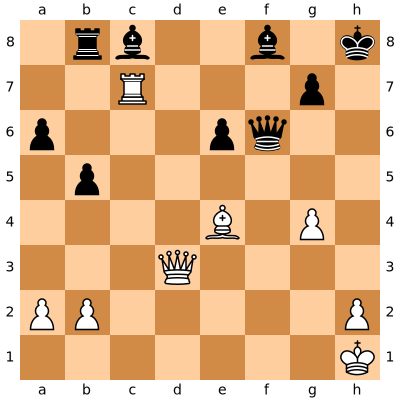

In [0]:
#example
fen = get_fen_from_picture('/gdrive/My Drive/new/test1.PNG', model)
print (fen)
chess.Board(fen)
